<a href="https://colab.research.google.com/github/Sahel-Eskandar/DataScience-Projects/blob/main/17-%20Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/Dataset.csv')
#df = df.set_index(['user','item'])
df.head()

,user,item,x,observed,liked
0,1,1,1.546881,1,1
1,1,2,0.850043,1,1
2,1,3,0.344194,1,1
3,1,4,1.621203,1,1
4,1,5,0.714086,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user      2800 non-null   int64  
 1   item      2800 non-null   int64  
 2   x         2800 non-null   float64
 3   observed  2800 non-null   int64  
 4   liked     2800 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 109.5 KB


# Find the signal put into data

In [ ]:
dfs = df.reset_index().pivot(columns='item',index='user',values='liked')

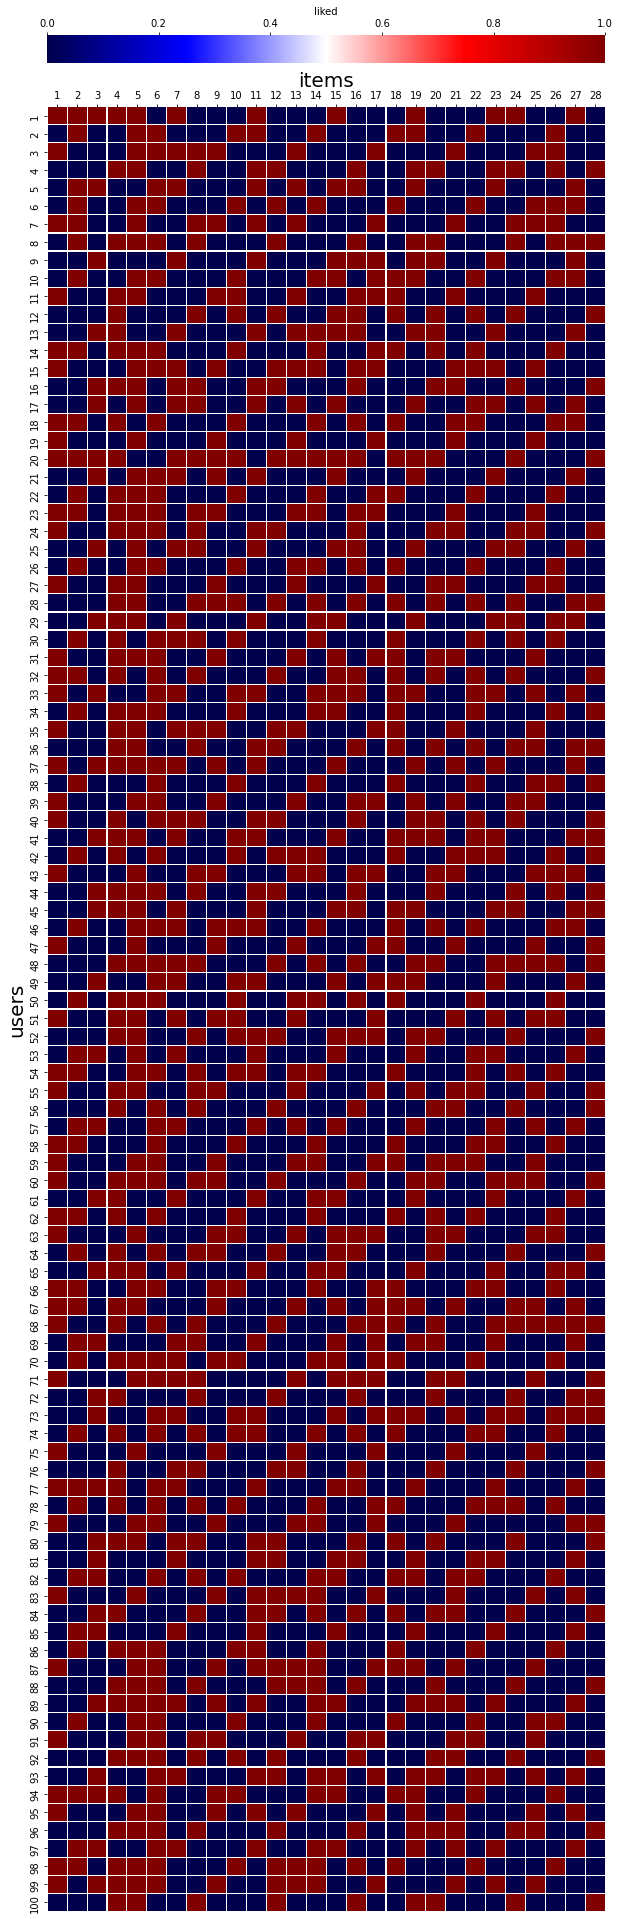

In [ ]:
fig, ax = plt.subplots(figsize=(10, 40))
cbar_kws=dict(use_gridspec=False,location="top",pad=0.02,shrink=1)
sns.heatmap(dfs, cmap= 'seismic', cbar_kws = cbar_kws,vmin=0,vmax=1,linewidths=0.1)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel('items', fontsize=20)
ax.set_ylabel('users', fontsize=20)
ax.collections[0].colorbar.set_label("liked")

Diagonal signals are visible in data
To clean the added signal diagonal cells were replaced by 0 instead of 1

In [ ]:
df0 = dfs.copy()

In [ ]:
for i in range(2,100,4):
  j = 0
  #print('i is:', i)
  while i >= 0 and j < 28:
    df0.iloc[i, j] = 0
    i -= 1
    j += 1
for i in range(103, 127,4):
  j = i%100
  i = 99
  #print('i is:',99)
  while i >= 0 and j < 28:
    df0.iloc[i, j] = 0
    i -= 1
    j += 1


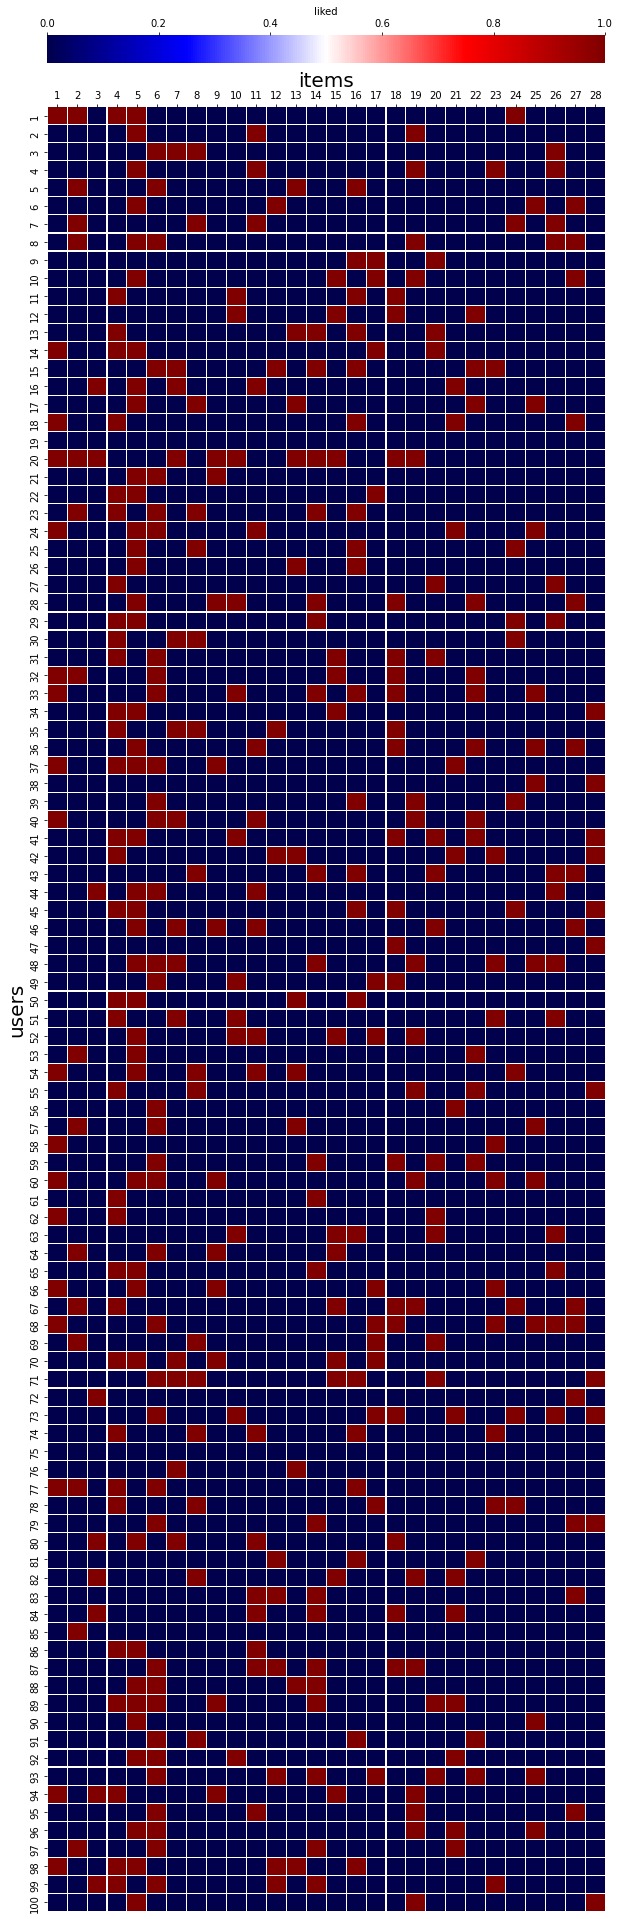

In [ ]:
fig, ax = plt.subplots(figsize=(10, 40))
cbar_kws=dict(use_gridspec=False,location="top",pad=0.02,shrink=1)
sns.heatmap(df0, cmap= 'seismic', cbar_kws = cbar_kws,vmin=0,vmax=1,linewidths=0.1)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel('items', fontsize=20)
ax.set_ylabel('users', fontsize=20)
ax.collections[0].colorbar.set_label("liked")

In [ ]:
df0.head()

item,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
user,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
5,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_i = df[df.user == 1]

In [ ]:
user_i.liked = df0.iloc[0,:].values

In [ ]:
df_base = user_i.copy()

In [ ]:
for u in range(2,101):
  user_i = df[df.user == u]
  user_i.liked = df0.iloc[u-1,:].values
  df_base = df_base.append(user_i, ignore_index=True)

# Divide Data to Train and Test

Train data which are observed

Test data which aren't observed

In [ ]:
df_base = df_base.rename(columns={'user':'userID','item':'itemID','liked':'rating'})

In [ ]:
dftrain = df_base[df_base.observed==1]
dftest = df_base[df_base.observed==0]
dftrain = dftrain.drop(['observed'], axis = 1)
dftest = dftest.drop(['observed'], axis = 1)

In [ ]:
dftrain.reset_index(inplace=True,drop= True)
dftest.reset_index(inplace=True,drop= True)

#Visualize train set

In [ ]:
df1 = dftrain.reset_index().pivot(columns='itemID',index='userID',values='rating')

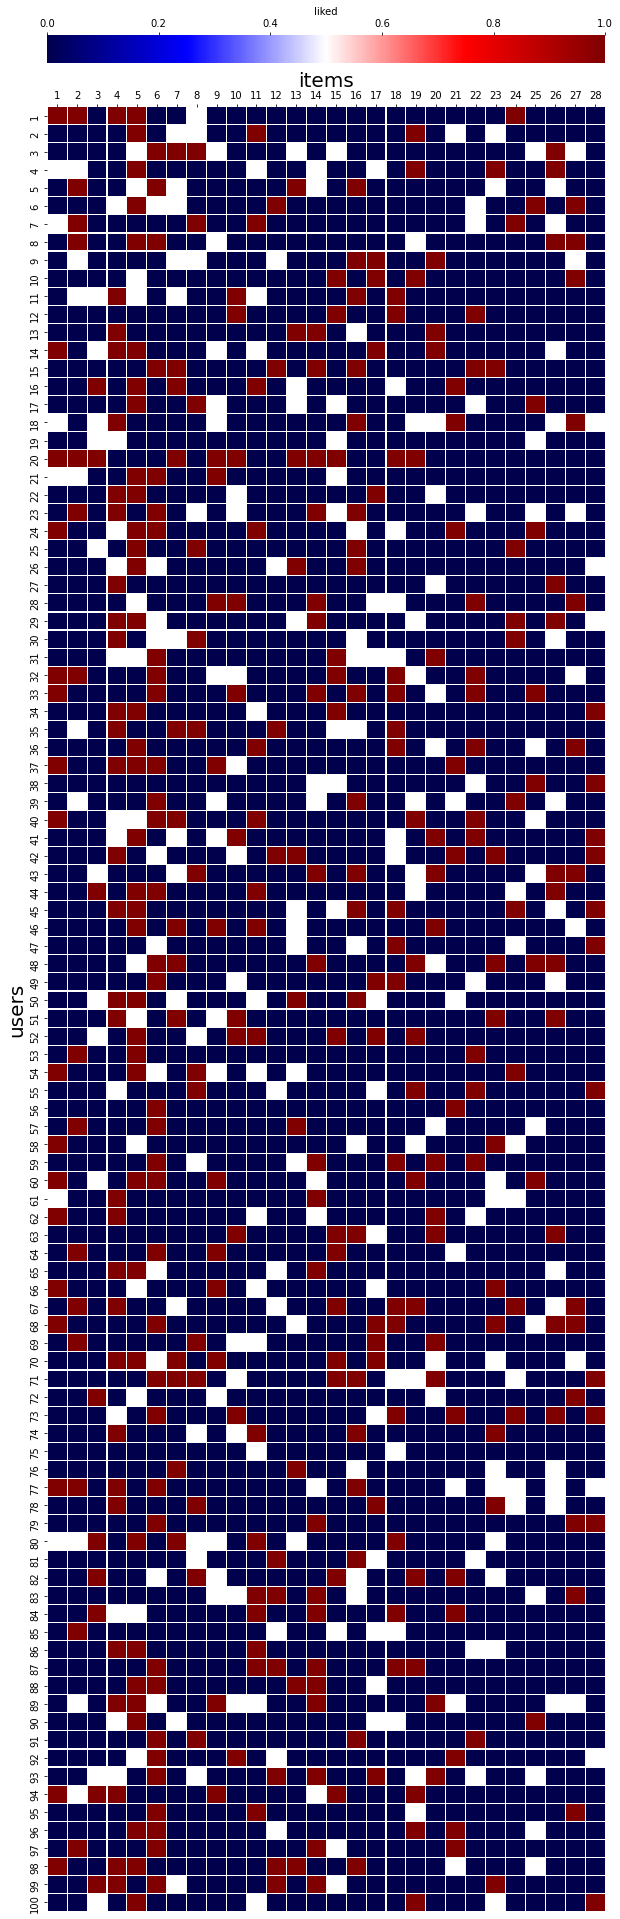

In [ ]:
fig, ax = plt.subplots(figsize=(10, 40))
cbar_kws=dict(use_gridspec=False,location="top",pad=0.02,shrink=1)
sns.heatmap(df1, cmap= 'seismic', cbar_kws = cbar_kws,vmin=0,vmax=1,linewidths=0.1)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel('items', fontsize=20)
ax.set_ylabel('users', fontsize=20)
ax.collections[0].colorbar.set_label("liked")

# Popular items

In [ ]:
popular_items = df1.sum(axis=0,numeric_only = True)
most_popular = popular_items.sort_values(ascending=False)
most_popular.head(10)

itemID
5     36.0
6     35.0
4     30.0
14    21.0
16    20.0
1     17.0
18    17.0
11    16.0
19    15.0
2     15.0
dtype: float64

How many items each user liked

In [ ]:
print(df1.sum(axis=1,numeric_only = True).count)

<bound method Series.count of userID
1      5.0
2      3.0
3      4.0
4      4.0
5      4.0
      ... 
96     4.0
97     4.0
98     6.0
99     6.0
100    3.0
Length: 100, dtype: float64>


In [ ]:
df1.head()

itemID,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
userID,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,0.0
4,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,NaN,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0


## Item-Item Similarity
Calculating cosin similarity matrix

In [ ]:
def Cosine(data):
  data_sparse = sparse.csr_matrix(data)
  similarity = cosine_similarity(data_sparse.transpose())
  Cos = pd.DataFrame(data=similarity, index= data.columns, columns= data.columns)
  return Cos

In [ ]:
df1 = df1.fillna(0)

In [ ]:
cos_item_matrix = Cosine(df1)
print('10 first similar items to the item #1')
print(cos_item_matrix.iloc[0].nlargest(10))

10 first similar items to the item #1
itemID
1     1.000000
9     0.365636
6     0.327968
4     0.309965
5     0.282958
25    0.257248
2     0.250490
19    0.250490
18    0.235294
23    0.219382
Name: 1, dtype: float64


## User-User Similarity
Calculate cosin similarity matrix

In [ ]:
# Build the similarity matrix
cos_user_matrix = Cosine(df1.transpose())

In [ ]:
print('10 first similar users to the user # 1')
print(cos_user_matrix.iloc[0].nlargest(10))

10 first similar users to the user # 1
userID
1     1.000000
54    0.670820
14    0.600000
29    0.600000
77    0.600000
37    0.547723
45    0.547723
98    0.547723
22    0.516398
30    0.516398
Name: 1, dtype: float64


Using Cosine Similarity find the most similar user behaviours

In [ ]:
data_neighbours = pd.DataFrame(index=cos_user_matrix.columns, columns=range(1,7))
for i in range(0, len(cos_user_matrix.columns)):
    data_neighbours.iloc[i,:6] = cos_user_matrix.iloc[0:,i].sort_values(ascending=False)[:6].index

In [ ]:
data_neighbours.drop(columns=[1],axis= 0).head(10)

,2,3,4,5,6
userID,,,,,
1,54,77,29,14,45
2,52,86,100,96,4
3,71,48,91,51,8
4,100,2,48,96,29
5,57,77,23,39,26
6,90,17,83,8,36
7,30,69,85,54,25
8,44,53,57,21,95
9,69,14,63,93,43


The users with similar bahaviour with the user # 1

In [ ]:
for i in data_neighbours.iloc[0].values:
  known_user_likes = df1.iloc[i-1]
  known_user_likes = known_user_likes[known_user_likes >0].index.values
  print('Items liked by user #',i,'are:',known_user_likes)

Items liked by user # 1 are: [ 1  2  4  5 24]
Items liked by user # 54 are: [ 1  5  8 24]
Items liked by user # 77 are: [ 1  2  4  6 16]
Items liked by user # 29 are: [ 4  5 14 24 26]
Items liked by user # 14 are: [ 1  4  5 17 20]
Items liked by user # 45 are: [ 4  5 16 18 24 28]


In [ ]:
for i in data_neighbours.iloc[8].values:
  known_user_likes = df1.iloc[i-1]
  known_user_likes = known_user_likes[known_user_likes >0].index.values
  print('Items liked by user #',i,'are:',known_user_likes)

Items liked by user # 9 are: [16 17 20]
Items liked by user # 69 are: [ 2  8 17 20]
Items liked by user # 14 are: [ 1  4  5 17 20]
Items liked by user # 63 are: [10 15 16 20 26]
Items liked by user # 93 are: [ 6 12 14 17 20]
Items liked by user # 43 are: [ 8 14 16 20 26 27]


##Cosine_item_Neighbours 

In [ ]:
all_data_neighbours = pd.DataFrame(index=cos_item_matrix.columns, columns=range(1,28))
for i in range(0, len(cos_item_matrix.columns)):
    all_data_neighbours.iloc[i,:27] = cos_item_matrix.iloc[0:,i].sort_values(ascending=False)[:27].index

In [ ]:
res = {}
for user_index in range(len(all_data_neighbours)):
  known_user_likes = df1.iloc[user_index]
  known_user_likes = known_user_likes[known_user_likes >0].index.values
  most_similar_to_likes = all_data_neighbours.iloc[known_user_likes]
  similar_list = most_similar_to_likes.values.tolist()
  similar_list = list(set([item for sublist in similar_list for item in sublist]))
  neighbourhood = cos_item_matrix[similar_list].loc[similar_list]
  user_vector = df1.iloc[user_index].loc[similar_list]
  score = neighbourhood.dot(user_vector).div(neighbourhood.sum(axis=1))
  score = score.drop(index=known_user_likes,errors='ignore')
  score.sort_values(ascending= False)
  top3 = list(score.nlargest(3).index.values)
  res[user_index] = top3
  print('item',user_index+1, 'is similar to items', top3)
#print(res)

item 1 is similar to items [9, 13, 16]
item 2 is similar to items [3, 25, 21]
item 3 is similar to items [23, 24, 20]
item 4 is similar to items [25, 11, 7]
item 5 is similar to items [14, 1, 12]
item 6 is similar to items [11, 14, 6]
item 7 is similar to items [5, 16, 18]
item 8 is similar to items [24, 25, 11]
item 9 is similar to items [8, 4, 15]
item 10 is similar to items [9, 20, 3]
item 11 is similar to items [24, 22, 13]
item 12 is similar to items [28, 19, 2]
item 13 is similar to items [12, 16, 17]
item 14 is similar to items [9, 16, 24]
item 15 is similar to items [13, 26, 25]
item 16 is similar to items [19, 9, 25]
item 17 is similar to items [24, 28, 11]
item 18 is similar to items [24, 12, 13]
item 19 is similar to items []
item 20 is similar to items [22, 6, 11]
item 21 is similar to items [25, 1, 21]
item 22 is similar to items [20, 24, 9]
item 23 is similar to items [13, 24, 12]
item 24 is similar to items [9, 19, 3]
item 25 is similar to items [4, 28, 2]
item 26 is sim

#Machine Learning

In [ ]:
dftrain.head()

,userID,itemID,x,rating
0,1,1,1.546881,1
1,1,2,0.850043,1
2,1,3,0.344194,0
3,1,4,1.621203,1
4,1,5,0.714086,1


In [ ]:
x_train, y_train = dftrain.drop(["rating"], axis = 1), dftrain["rating"]

In [ ]:
dftest.head()

,userID,itemID,x,rating
0,1,8,-1.341051,0
1,2,7,-1.922255,0
2,2,8,-0.045707,0
3,2,21,-0.425549,0
4,2,23,-0.814992,0


In [ ]:
x_test, y_test = dftest.drop(["rating"], axis = 1), dftest["rating"]

In [ ]:
from sklearn.metrics import mean_squared_error
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

##XGB

In [ ]:
import xgboost as xgb
clf = xgb.XGBRegressor(objective="binary:logistic", random_state=42)
clf.fit(x_train, y_train)

XGBRegressor(objective='binary:logistic', random_state=42)

In [ ]:
y_pred_test = clf.predict(x_test)

In [ ]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))
print("score on test: " + str(clf.score(x_test, y_test)))
print("score on train: "+ str(clf.score(x_train, y_train)))

RMSE = 0.2584993890691428
score on test: 0.4681940425962886
score on train: 0.5622412666084355


##KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

print("score on test: " + str(knn.score(x_test, y_test)))
print("score on train: "+ str(knn.score(x_train, y_train)))

score on test: 0.856140350877193
score on train: 0.8815109343936381


In [ ]:
dftest['knn_prediction'] = knn.predict(x_test)

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
print("score on test: " + str(lr.score(x_test, y_test)))
print("score on train: "+ str(lr.score(x_train, y_train)))

score on test: 0.8807017543859649
score on train: 0.8767395626242545


In [ ]:
dftest['lr_prediction'] = lr.predict(x_test)

##SVM

In [ ]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)
svm.fit(x_train, y_train)
print("score on test: " + str(svm.score(x_test, y_test)))
print("score on train: "+ str(svm.score(x_train, y_train)))

score on test: 0.8596491228070176
score on train: 0.8357852882703777


In [ ]:
dftest['svm_prediction'] = svm.predict(x_test)

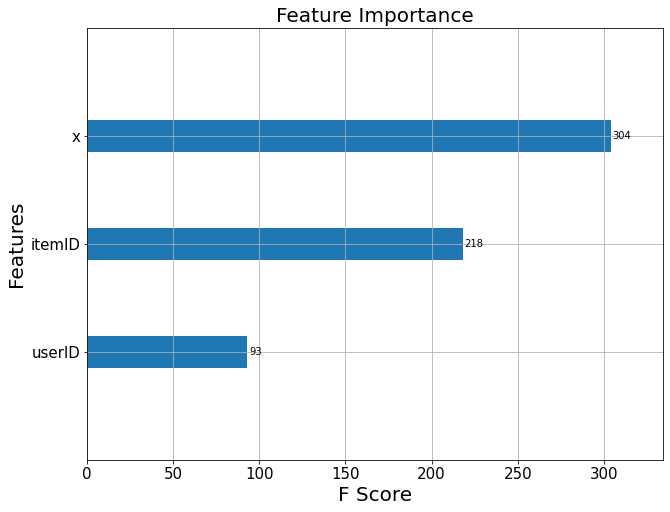

In [ ]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()
plot_importance(xgb, clf)